In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers   import Adam
from tensorflow.keras.callbacks    import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers as L
from tensorflow.keras import models as M
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers as L, models as M, regularizers

# Load data

In [2]:
import pandas as pd

In [3]:
X = np.load('images.npy')
labels = np.load('labels.npy')
X_test = np.load('images_sub.npy')

In [4]:
X.shape, labels.shape, X_test.shape

((20000, 48, 48, 3), (20000,), (50000, 48, 48, 3))

# Check missing values

In [5]:
n_rows_with_na = np.isnan(X).any(axis=(1, 2, 3)).sum()
print(f"Missing rows: {n_rows_with_na}")

Missing rows: 0


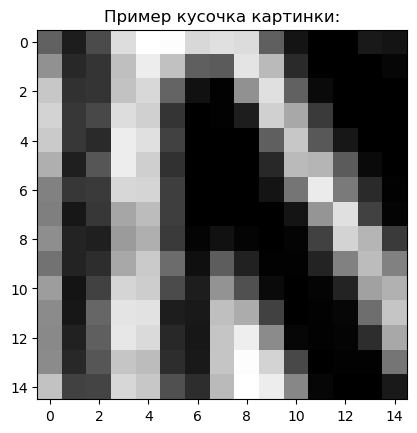

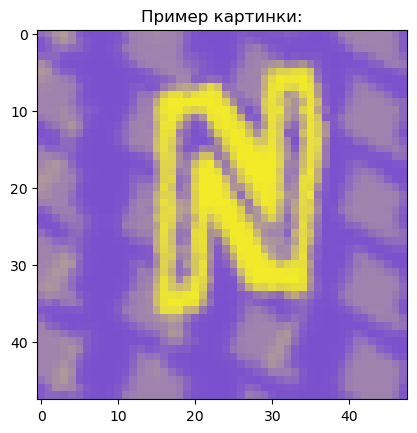

In [6]:
# Visualize a piece of an image
example_patch = X[0, 15:30, 15:30, 0]  # grayscale slice of first image
plt.title("Пример кусочка картинки:")
plt.imshow(example_patch, cmap='Greys')
plt.show()

# Show a full image example
plt.title("Пример картинки:")
plt.imshow(X[0])  # RGB image
plt.show()

# Get training datasets

In [7]:
# One-hot encode the labels (if you're doing classification)
labels_oh = to_categorical(labels, num_classes=26)
print("One-hot labels shape:", labels_oh.shape)
print("First 5 one-hot labels:\n", labels_oh[:5])
print("Corresponding labels:\n", labels[:5])

One-hot labels shape: (20000, 26)
First 5 one-hot labels:
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]]
Corresponding labels:
 [13 24  8 13 13]


In [8]:
# Split into training and validation (80% train, 20% val)
x_train, x_val, y_train, y_val = train_test_split(
    X, labels_oh, test_size=0.2, random_state=42, stratify=labels
)

# Print shapes to confirm
print("x_train shape:", x_train.shape)
print("x_val shape:", x_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

x_train shape: (16000, 48, 48, 3)
x_val shape: (4000, 48, 48, 3)
y_train shape: (16000, 26)
y_val shape: (4000, 26)


In [9]:
# центрируем и нормируем
x_train_float = x_train.astype(np.float32) / 255 - 0.5
x_val_float = x_val.astype(np.float32) / 255 - 0.5

# Train

In [10]:
datagen = ImageDataGenerator(
  rotation_range=15,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.1,
  brightness_range=(0.8,1.2),
  horizontal_flip=False,
  fill_mode='nearest'
)


# Fit the generator to the training data
datagen.fit(x_train_float)

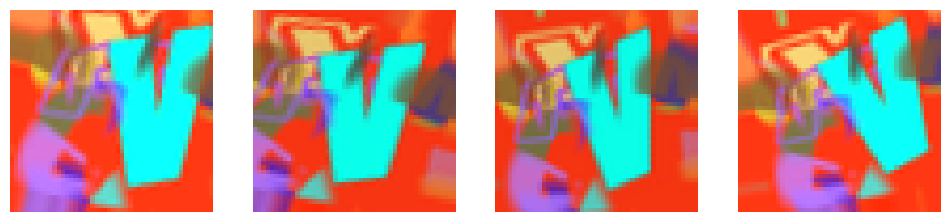

In [11]:
# Pick a single image, add a dummy batch axis
img = x_train[0]
batch = img.reshape((1, *img.shape))

# Create an iterator
it = datagen.flow(batch, batch_size=1)

# Plot four random augmentations
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    augmented = next(it)[0].astype('uint8')
    axes[i].imshow(augmented)
    axes[i].axis('off')
plt.show()

In [12]:
model = M.Sequential([
    L.Input(shape=(48, 48, 3)),

    # Block 1
    L.Conv2D(32, 3, padding='same',
             kernel_regularizer=regularizers.l2(1e-4)),
    L.BatchNormalization(),
    L.Activation('relu'),
    L.MaxPooling2D(),
    L.Dropout(0.05),

    # Block 2
    L.Conv2D(64, 3, padding='same',
             kernel_regularizer=regularizers.l2(1e-4)),
    L.BatchNormalization(),
    L.Activation('relu'),
    L.MaxPooling2D(),
    L.Dropout(0.05),

    # Block 3
    L.Conv2D(128, 3, padding='same',
             kernel_regularizer=regularizers.l2(1e-4)),
    L.BatchNormalization(),
    L.Activation('relu'),
    L.MaxPooling2D(),
    L.Dropout(0.05),

    # Block 4
    L.Conv2D(256, 3, padding='same', kernel_regularizer=regularizers.l2(1e-4)),
    L.BatchNormalization(),
    L.Activation('relu'),
    L.MaxPooling2D(),
    L.Dropout(0.05),

    # Classification head
    L.GlobalAveragePooling2D(),
    L.Dense(128, activation='relu'),
    L.Dropout(0.5),
    L.Dense(26, activation='softmax'),
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 426,586 (1.63 MB)

 Trainable params: 425,626 (1.62 MB)

 Non-trainable params: 960 (3.75 KB)

In [13]:
# Compile
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           verbose=1)
reduce_lr  = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.5,
                               patience=5,
                               min_lr=1e-6,
                               verbose=1)


# Train
history = model.fit(
    datagen.flow(x_train_float, y_train, batch_size=32),
    epochs=100,
    steps_per_epoch=len(x_train_float)//32,
    validation_data=(x_val_float, y_val),
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


500/500 ━━━━━━━━━━━━━━━━━━━━ 33s 63ms/step - accuracy: 0.0427 - loss: 3.3645 - val_accuracy: 0.0477 - val_loss: 3.2743 - learning_rate: 0.0010
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 35s 70ms/step - accuracy: 0.0469 - loss: 3.2707 - val_accuracy: 0.0490 - val_loss: 3.2261 - learning_rate: 0.0010
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 39s 77ms/step - accuracy: 0.0535 - loss: 3.2341 - val_accuracy: 0.0575 - val_loss: 3.1695 - learning_rate: 0.0010
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 76ms/step - accuracy: 0.0551 - loss: 3.1954 - val_accuracy: 0.0805 - val_loss: 3.0659 - learning_rate: 0.0010
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - accuracy: 0.0632 - loss: 3.1487 - val_accuracy: 0.0840 - val_loss: 2.9994 - learning_rate: 0.0010
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 44s 87ms/step - accuracy: 0.0662 - loss: 3.1267 - val_accuracy: 0.0922 - val_loss: 2.9790 - learning_rate: 0.0010
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - accuracy: 0.0682 - loss: 

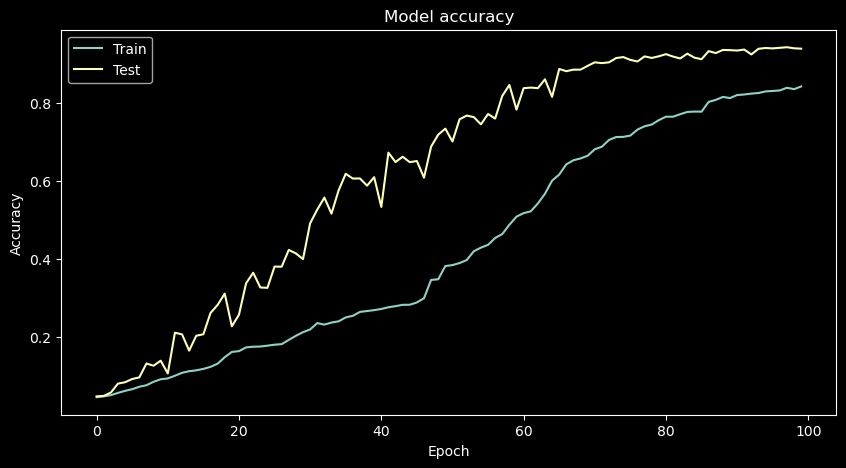

In [14]:
# Plot training & validation accuracy values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

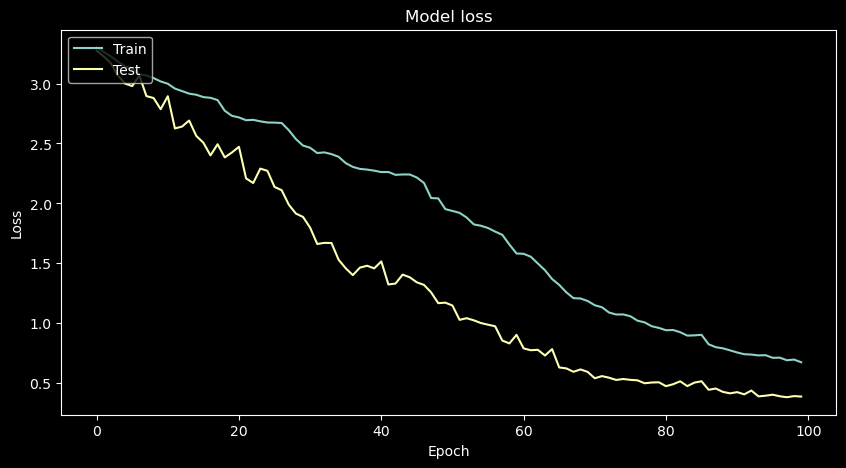

In [15]:
# Plot training & validation loss values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [16]:
loss, acc = model.evaluate(x_val_float, y_val, batch_size=32)
print("Keras-evaluate accuracy:", acc)

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9425 - loss: 0.3829
Keras-evaluate accuracy: 0.9430000185966492


In [17]:
preds = model.predict(x_val_float)
pred_classes = np.argmax(preds, axis=1)
true_classes = np.argmax(y_val, axis=1)

print("Val Accuracy:", accuracy_score(true_classes, pred_classes))

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step
Val Accuracy: 0.943


# Predict on test

In [18]:
# Preprocess X_test like training data
X_test_float = X_test.astype(np.float32) / 255 - 0.5

# Predict using your trained model
predictions = model.predict(X_test_float)

# Get predicted class indices
predicted_classes = np.argmax(predictions, axis=1)

# Create submission DataFrame
submission_df = pd.DataFrame({
    'Id': np.arange(len(predicted_classes)),
    'Category': predicted_classes
})

# Save to CSV
submission_df.to_csv('submission_letters.csv', index=False)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step


In [19]:
print(submission_df.head())

   Id  Category
0   0        19
1   1        21
2   2        14
3   3        12
4   4        10
